# Loading Libraries and Data

Importing Libraries

In [56]:
from tensorflow.keras.layers import Dense, Input, LSTM, Dropout
from tensorflow.keras.layers import Reshape, TimeDistributed
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import random
import random as rand

Loading in AqSolDB Data

Citation:

Sorkun, M.C., Khetan, A. & Er, S. AqSolDB, a curated reference set of aqueous solubility and 2D descriptors for a diverse set of compounds. *Sci Data* **6**, 143 (2019). https://doi.org/10.1038/s41597-019-0151-1

In [57]:
solubility_data = pd.read_csv('/content/curated-solubility-dataset.csv')
smiles_notation = []
solubility = []
NRB = []
NVE = []
NArR = []
NSR = []
NAlR = []
RC = []
TPSA = []
LASA = []
BalabanJ = []
BertzCT = []
MolWt = []
SD = []
MLP = []
MMR = []
HAC = []
NHA = []
NHD = []
for row in solubility_data.iterrows():
  smiles_notation.append(row[1]['SMILES'])
  solubility.append(float(row[1]['Solubility']))
  NRB.append(float(row[1]['NumRotatableBonds']))
  NVE.append(float(row[1]['NumValenceElectrons']))
  NArR.append(float(row[1]['NumAromaticRings']))
  NSR.append(float(row[1]['NumSaturatedRings']))
  NAlR.append(float(row[1]['NumAliphaticRings'])) 
  RC.append(float(row[1]['RingCount']))
  TPSA.append(float(row[1]['TPSA']))
  LASA.append(float(row[1]['LabuteASA']))
  BalabanJ.append(float(row[1]['BalabanJ']))
  BertzCT.append(float(row[1]['BertzCT']))
  MolWt.append(float(row[1]['MolWt']))
  SD.append(float(row[1]['SD']))
  MLP.append(float(row[1]['MolLogP']))
  MMR.append(float(row[1]['MolMR']))
  HAC.append(float(row[1]['HeavyAtomCount']))
  NHA.append(float(row[1]['NumHAcceptors']))
  NHD.append(float(row[1]['NumHDonors']))

solubility_data.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


Ragged Function

In [58]:
def stack_ragged(tensors):  # So only middle dimension can have shape None, and for combining ragged tensors
    values = tf.concat(tensors, axis=0)
    lens = tf.stack([tf.shape(t, out_type=tf.int64)[0] for t in tensors])
    return tf.RaggedTensor.from_row_lengths(values, lens)

# Preprocessing Data

Making list of unique characters

In [59]:
unique_chars = []
uni_char_dict = {}
uni_chars = 0
for notat in smiles_notation:
  for char in notat:
    unique = True
    for chr in unique_chars:
      if chr == char:
        unique = False
    if unique:
      unique_chars.append(char)
      uni_char_dict[char] = len(unique_chars) - 1

print(unique_chars) 
print(uni_char_dict)

['[', 'B', 'r', '-', ']', '.', 'C', 'N', '+', '(', ')', 'O', '=', '1', 'c', '2', '3', 'l', 'Z', 'n', '4', '5', '6', 'F', '\\', '/', 'P', 'S', 'a', 'A', 'i', 'M', 'o', 's', '@', 'H', 'W', 'b', '#', '7', '8', 'V', 'g', 'e', 'K', 'T', '9', '%', '0', 'd', 'I', 'R', 'u', 'L', 'G', 'D', 'y', 'Y', 'h', 'f', 'm', 't', ' ']
{'[': 0, 'B': 1, 'r': 2, '-': 3, ']': 4, '.': 5, 'C': 6, 'N': 7, '+': 8, '(': 9, ')': 10, 'O': 11, '=': 12, '1': 13, 'c': 14, '2': 15, '3': 16, 'l': 17, 'Z': 18, 'n': 19, '4': 20, '5': 21, '6': 22, 'F': 23, '\\': 24, '/': 25, 'P': 26, 'S': 27, 'a': 28, 'A': 29, 'i': 30, 'M': 31, 'o': 32, 's': 33, '@': 34, 'H': 35, 'W': 36, 'b': 37, '#': 38, '7': 39, '8': 40, 'V': 41, 'g': 42, 'e': 43, 'K': 44, 'T': 45, '9': 46, '%': 47, '0': 48, 'd': 49, 'I': 50, 'R': 51, 'u': 52, 'L': 53, 'G': 54, 'D': 55, 'y': 56, 'Y': 57, 'h': 58, 'f': 59, 'm': 60, 't': 61, ' ': 62}


Embedding text data into numbers

In [60]:
prep_smilenot = []
for notat in smiles_notation:
  prep_smil = []
  for char in notat:
    char_lis = [0.0]*len(unique_chars)
    char_lis[uni_char_dict[char]] = 1.0
    prep_smil.append(char_lis)
  prep_smilenot.append(prep_smil)
extra_inputs = [NRB, NVE, NArR, NSR, NAlR, RC, TPSA, LASA, BalabanJ, BertzCT, MolWt, SD, MLP, MMR, HAC, NHA, NHD] # All of them
prep_eis = []
for i in range(len(extra_inputs[0])):
  prep_ei = []
  for inp in extra_inputs:
    if (inp == LASA) or (inp == TPSA) or (inp == BertzCT) or (inp == MolWt) or (inp == NVE) or (inp == HAC) or (inp == MMR): # Scaling down inputs x100
      prep_ei.append(inp[i] / 100) 
    elif inp == BalabanJ: # Scale up for BalabanJ
      prep_ei.append(inp[i] * 10)
    else:
      prep_ei.append(inp[i])
  prep_eis.append(prep_ei)

psn_train, psn_test, solu_train, solu_test, ei_train, ei_test = train_test_split(prep_smilenot, solubility, prep_eis, test_size=0.2)
psn_train, psn_test = stack_ragged(psn_train), stack_ragged(psn_test)
solu_train, solu_test = np.array(solu_train), np.array(solu_test)
ei_train, ei_test = np.array(ei_train), np.array(ei_test)

# Defining Model Class

In [61]:
class NLPSM():
  def __init__(self, unique_chars, extra_inputs=0):

    # Defining vars

    self.unique_chars = unique_chars
    self.extra_inputs = extra_inputs

    # Building model

    self.model = self.build_model()
    self.model.compile(optimizer='adam', loss='mae')

  def build_model(self):

    # Processing text

    inputs = Input(shape=(None, self.unique_chars), ragged=True)
    result = TimeDistributed(Dense(500, activation='relu'))(inputs)
    result = LSTM(400)(result)
    result = Dense(400, activation='relu')(result)
    result = Dense(400, activation='relu')(result)

    # Processing extra inputs and combining

    if self.extra_inputs > 0:
      inputs2 = Input(shape=self.extra_inputs)
      result2 = Dense(100*self.extra_inputs)(inputs2)
      result2 = Dense(400, activation='relu')(result2)
      result = tf.concat((result, result2), axis=-1)

    # Final Dense layers

    result = Dropout(0.3)(result)
    result = Dense(400, activation='relu')(result)    
    result = Dropout(0.3)(result)

    result = Dense(1)(result)

    # Defining model

    if self.extra_inputs == 0:
      model = Model(inputs, result, name='solubility_model_SMILES_only')
      print(model.summary())
      return model
    else: 
      model = Model([inputs, inputs2], result, name='solubility_model_extra_inputs')
      print(model.summary())
      return model



# Model Instancing, Training, and Analysis

Training Parameters

In [62]:
#@title Training Parameters { run: "auto", display-mode: "form" }
episodes = 100 #@param {type:"integer"}
batch_size = 100 #@param {type: "integer"}
verbose = "False" #@param ["False", "True"]

Setting Seed

In [63]:
seed = 1
rand.seed(seed)
random.set_seed(seed)

Instancing + Training Regular Model

In [64]:
solubility_model = NLPSM(unique_chars=len(unique_chars), extra_inputs = 0)
history_base = solubility_model.model.fit(psn_train, solu_train, validation_data = (psn_test, solu_test), epochs=episodes, batch_size=batch_size, verbose=eval(verbose))

Model: "solubility_model_SMILES_only"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, None, 63)]        0         
                                                                 
 time_distributed_13 (TimeDi  (None, None, 500)        32000     
 stributed)                                                      
                                                                 
 lstm_21 (LSTM)              (None, 400)               1441600   
                                                                 
 dense_64 (Dense)            (None, 400)               160400    
                                                                 
 dense_65 (Dense)            (None, 400)               160400    
                                                                 
 dropout_26 (Dropout)        (None, 400)               0         
                                      

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/solubility_model_SMILES_only/lstm_21/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/solubility_model_SMILES_only/lstm_21/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 500), dtype=float32), dense_shape=Tensor("gradient_tape/solubility_model_SMILES_only/lstm_21/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Instancing + Training  Extra Input Model

In [65]:
solubility_model = NLPSM(unique_chars=len(unique_chars), extra_inputs = len(extra_inputs))
history_ei = solubility_model.model.fit([psn_train, ei_train], solu_train, validation_data = ([psn_test, ei_test], solu_test), epochs=episodes, batch_size=batch_size, verbose=eval(verbose))

Model: "solubility_model_extra_inputs"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, None, 63)]   0           []                               
                                                                                                  
 time_distributed_14 (TimeDistr  (None, None, 500)   32000       ['input_20[0][0]']               
 ibuted)                                                                                          
                                                                                                  
 lstm_22 (LSTM)                 (None, 400)          1441600     ['time_distributed_14[0][0]']    
                                                                                                  
 input_21 (InputLayer)          [(None, 17)]         0           []   

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/solubility_model_extra_inputs/lstm_22/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/solubility_model_extra_inputs/lstm_22/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 500), dtype=float32), dense_shape=Tensor("gradient_tape/solubility_model_extra_inputs/lstm_22/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Plotting data

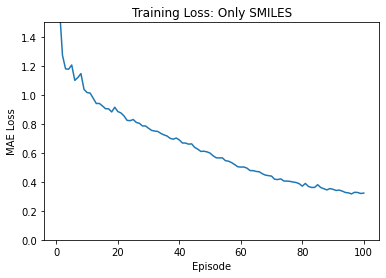

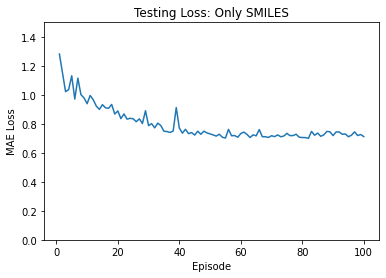

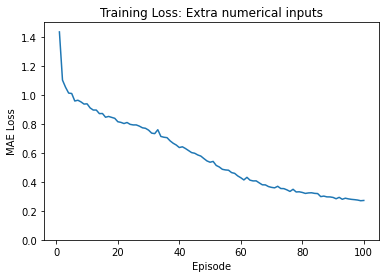

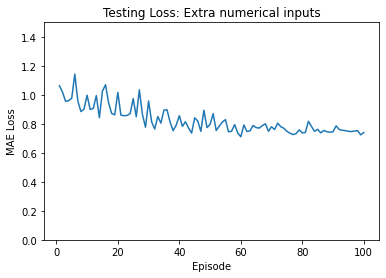

In [66]:
epochs = []
for i in range(episodes):
  epochs.append(i+1)

# Training Loss for SMILES only

plt.plot(epochs, history_base.history['loss'])
plt.title('Training Loss: Only SMILES')
plt.xlabel('Episode')
plt.ylabel('MAE Loss')
plt.ylim(0, 1.5)
plt.show()

# Testing Loss for SMILES only

plt.plot(epochs, history_base.history['val_loss'])
plt.title('Testing Loss: Only SMILES')
plt.xlabel('Episode')
plt.ylabel('MAE Loss')
plt.ylim(0, 1.5)
plt.show()

# Training Loss for Extra Inputs

plt.plot(epochs, history_ei.history['loss'])
plt.title('Training Loss: Extra numerical inputs')
plt.xlabel('Episode')
plt.ylabel('MAE Loss')
plt.ylim(0, 1.5)
plt.show()

# Testing Loss for Extra Inputs

plt.plot(epochs, history_ei.history['val_loss'])
plt.title('Testing Loss: Extra numerical inputs')
plt.xlabel('Episode')
plt.ylabel('MAE Loss')
plt.ylim(0, 1.5)
plt.show()